In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/cs-training.csv')  # Replace with correct path if needed

# Display basic info
print(df.head())
print(df.info())
print(df.isnull().sum())

# Drop the 'Unnamed: 0' column if present (index column)
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# Step 1: Handle missing values
# Fill MonthlyIncome with median
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)

# Fill NumberOfDependents with median
df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)

# Confirm missing values are handled
print("Missing values after cleaning:\n", df.isnull().sum())

# Step 2: Define features and target
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

# Step 3: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("✅ Data Preprocessing Complete — Ready for Feature Engineering")


   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                   

<ipython-input-1-8b30456e3bc3>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
<ipython-input-1-8b30456e3bc3>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

✅ Data Preprocessing Complete — Ready for Feature Engineering


In [2]:
# Convert resampled data back to DataFrame for engineering
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)

# Add new smart features 👇

# 1. Debt to Income Ratio
X_resampled_df['Debt_to_Income_Ratio'] = X_resampled_df['DebtRatio'] / (X_resampled_df['MonthlyIncome'] + 1)  # +1 to avoid division by zero

# 2. Is_Late_Payer: If any late payments > 0
X_resampled_df['Is_Late_Payer'] = (
    (X_resampled_df['NumberOfTime30-59DaysPastDueNotWorse'] +
     X_resampled_df['NumberOfTime60-89DaysPastDueNotWorse'] +
     X_resampled_df['NumberOfTimes90DaysLate']) > 0
).astype(int)

# 3. Has Dependents: If customer has any dependents
X_resampled_df['Has_Dependents'] = (X_resampled_df['NumberOfDependents'] > 0).astype(int)

# 4. Total_Past_Dues: Sum of all past due counts
X_resampled_df['Total_Past_Dues'] = (
    X_resampled_df['NumberOfTime30-59DaysPastDueNotWorse'] +
    X_resampled_df['NumberOfTime60-89DaysPastDueNotWorse'] +
    X_resampled_df['NumberOfTimes90DaysLate']
)

# Optional: Drop original features if needed
# X_resampled_df.drop(['DebtRatio', 'NumberOfDependents'], axis=1, inplace=True)

# Final scaling after feature engineering
scaler = StandardScaler()
X_final = scaler.fit_transform(X_resampled_df)

# Train-test split again with engineered features
X_train, X_test, y_train, y_test = train_test_split(X_final, y_resampled, test_size=0.2, random_state=42)

print("✅ Feature Engineering Complete — Smart features added and data ready for model training.")


✅ Feature Engineering Complete — Smart features added and data ready for model training.


In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb

# Define a function to train and evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"📊 Results for {name}:")
    print("Accuracy      :", accuracy_score(y_test, y_pred))
    print("Precision     :", precision_score(y_test, y_pred))
    print("Recall        :", recall_score(y_test, y_pred))
    print("F1 Score      :", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 50)

# 1. Random Forest
rf = RandomForestClassifier(random_state=42)
evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test)

# 2. Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
evaluate_model("Gradient Boosting", gb, X_train, y_train, X_test, y_test)

# 3. XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test)


📊 Results for Random Forest:
Accuracy      : 0.9394891944990177
Precision     : 0.9488196136917537
Recall        : 0.929413860680563
F1 Score      : 0.9390164878680971
Confusion Matrix:
 [[26518  1407]
 [ 1981 26084]]
--------------------------------------------------
📊 Results for Gradient Boosting:
Accuracy      : 0.86286836935167
Precision     : 0.8738127544097694
Recall        : 0.8490290397292001
F1 Score      : 0.861242635630896
Confusion Matrix:
 [[24484  3441]
 [ 4237 23828]]
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Results for XGBoost:
Accuracy      : 0.9341668155027684
Precision     : 0.9621260947037191
Recall        : 0.9042579725636914
F1 Score      : 0.9322949193637265
Confusion Matrix:
 [[26926   999]
 [ 2687 25378]]
--------------------------------------------------


In [4]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_tuned = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf_tuned,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1,
                                   scoring='f1')  # or 'accuracy'

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_

# Evaluate the tuned model
evaluate_model("Tuned Random Forest", best_rf, X_train, y_train, X_test, y_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


📊 Results for Tuned Random Forest:
Accuracy      : 0.9449544561528844
Precision     : 0.9564105374693996
Recall        : 0.9326919650810618
F1 Score      : 0.9444023523469351
Confusion Matrix:
 [[26732  1193]
 [ 1889 26176]]
--------------------------------------------------


<ipython-input-5-8b7e36cf6577>:14: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


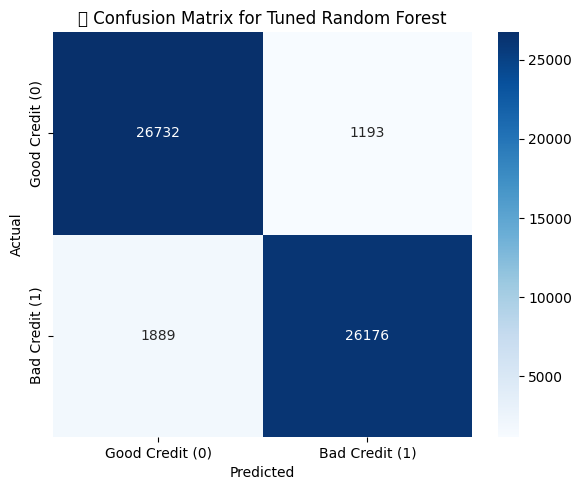

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Good Credit (0)', 'Bad Credit (1)']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'📉 Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Example usage after predictions
y_pred_rf = best_rf.predict(X_test)  # Replace with X_test_enn if using SMOTEENN
plot_conf_matrix("Tuned Random Forest", y_test, y_pred_rf)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
📊 Results for Tuned XGBoost:
Accuracy      : 0.9381853902482586
Precision     : 0.9670463173880031
Recall        : 0.9076073401033316
F1 Score      : 0.9363845234812976
Confusion Matrix:
 [[27057   868]
 [ 2593 25472]]
--------------------------------------------------


<ipython-input-5-8b7e36cf6577>:14: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


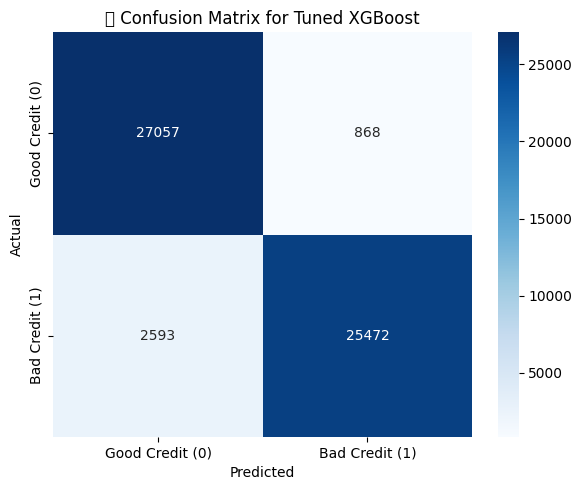

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Step 1: Setup model
xgb = XGBClassifier(random_state=42, n_jobs=-1)

# Step 2: Define hyperparameter grid
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
}

# Step 3: Random search CV
xgb_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=20, scoring='accuracy',
    cv=3, verbose=1, random_state=42
)

# Step 4: Fit on normal training data (not SMOTEENN)
xgb_search.fit(X_train, y_train)

# Step 5: Evaluate best XGB
best_xgb = xgb_search.best_estimator_
evaluate_model("Tuned XGBoost", best_xgb, X_train, y_train, X_test, y_test)

# Step 6: Confusion Matrix
y_pred_xgb = best_xgb.predict(X_test)
plot_conf_matrix("Tuned XGBoost", y_test, y_pred_xgb)



In [11]:
# For XGBoost (you can also try RF)
importances = best_xgb.feature_importances_
# Get the feature names from the DataFrame before it was converted to a NumPy array
feature_names = X_resampled_df.columns  # Assuming X_resampled_df is your original DataFrame

# Plot



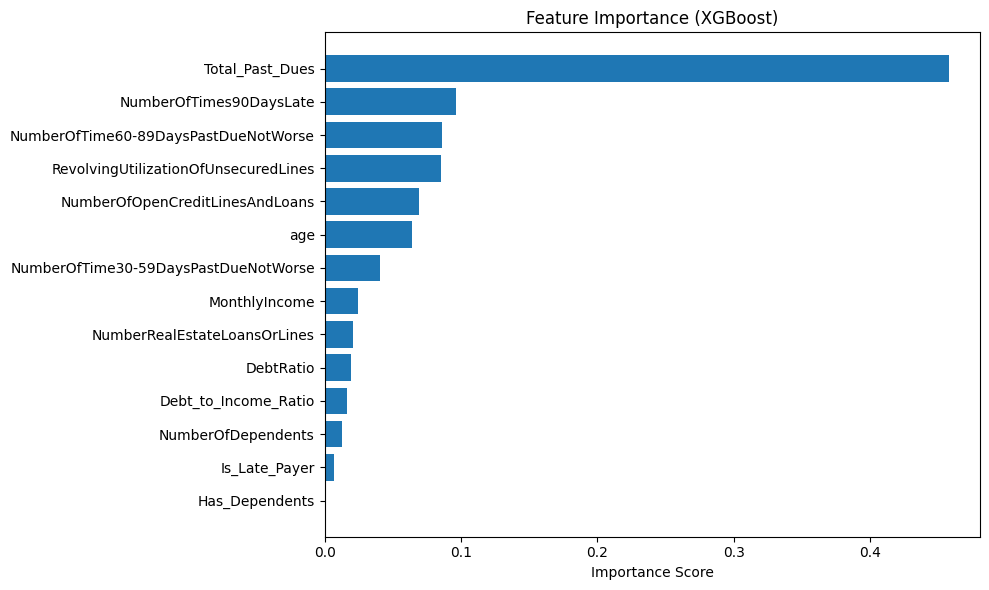

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# For XGBoost (you can also try RF)
importances = best_xgb.feature_importances_
# Get the feature names from the original DataFrame (X_resampled_df)
feature_names = X_resampled_df.columns  # Assuming X_resampled_df is your original DataFrame with column names

# Plot
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'])
plt.xlabel("Importance Score")
plt.title("Feature Importance (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [14]:
def predict_credit_risk(input_data):
    # input_data: numpy array or DataFrame row
    return stack_model.predict(input_data)

# Example usage:
# new_customer = pd.DataFrame([...], columns=X_train.columns)
# prediction = predict_credit_risk(new_customer)
